##### Copyright 2022 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Core API と DTensor による分散型トレーニング

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/ja/guide/core/distribution"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">     TensorFlow.org で表示</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/guide/core/distribution.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colabで実行</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/guide/core/distribution.ipynb">     <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">     GitHubでソースを表示</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/guide/core/distribution.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード</a></td>
</table>

## はじめに

このノートブックでは、[TensorFlow Core 低レベル API](https://www.tensorflow.org/guide/core) と [DTensor](https://www.tensorflow.org/guide/dtensor_overview) を使用して、データ並列分散型トレーニングの例を実演します。TensorFlow Core と意図する使用例の詳細については、[Core API の概要](https://www.tensorflow.org/guide/core)を参照してください。DTensor の詳細については、[DTensor の概要](https://www.tensorflow.org/guide/dtensor_overview)ガイドと [DTensor を使用した分散型トレーニング](https://www.tensorflow.org/tutorials/distribute/dtensor_ml_tutorial)チュートリアルを参照してください。

この例では、[多層パーセプトロン](https://www.tensorflow.org/guide/core/mlp_core)のチュートリアルと同じモデルとオプティマイザを使用しています。最初にこのチュートリアルを参照して、Core API を使用したエンドツーエンドの機械学習ワークフローの作成に精通してください。

注意: DTensor は、まだ実験的な TensorFlow API です。機能はテストに使用できますが、テスト環境でのみ使用することを意図しています。

## DTensor を使用したデータ並列トレーニングの概要

分散をサポートする MLP を構築する前に、データ並列トレーニングのための DTensor の基礎を見てみましょう。

DTensor を使用すると、デバイス間で分散型トレーニングを実行して、効率、信頼性、およびスケーラビリティを向上させることができます。DTensor は、Single program, multiple data（SPMD）と呼ばれるテクニックにより、シャーディングディレクティブに従ってプログラムとテンソルを分散します。`DTensor` 対応レイヤの変数は `dtensor.DVariable` として作成され、`DTensor` 対応レイヤオブジェクトのコンストラクタは通常のレイヤーパラメータに加えて追加の `Layout` 入力をとります。

データ並列トレーニングの主なアイデアは次のとおりです。

- モデル変数は、N 個のデバイスにそれぞれ複製されます。
- グローバルバッチは、N 個のレプリカごとのバッチに分割されます。
- それぞれのレプリカごとのバッチは、レプリカデバイスでトレーニングされます。
- 勾配は、すべてのレプリカでデータの重み付けが集団的に実行される前に減らされます。
- データ並列トレーニングは、デバイスの数に関してほぼ線形の速度を提供します

## セットアップ

DTensor は、TensorFlow 2.9.0 リリースに含まれています。

In [2]:
#!pip install --quiet --upgrade --pre tensorflow

In [3]:
import matplotlib
from matplotlib import pyplot as plt
# Preset Matplotlib figure sizes.
matplotlib.rcParams['figure.figsize'] = [9, 6]

In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.experimental import dtensor
print(tf.__version__)
# Set random seed for reproducible results 
tf.random.set_seed(22)

2024-01-11 19:08:26.744480: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-11 19:08:26.744524: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-11 19:08:26.746184: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.15.0


この実験のために 8 つの仮想 CPU を構成します。DTensor は、GPU または TPU デバイスでも使用できます。このノートブックでは仮想デバイスを使用しているので、分散型トレーニングによる速度の向上はほぼ見られません。 

In [5]:
def configure_virtual_cpus(ncpu):
  phy_devices = tf.config.list_physical_devices('CPU')
  tf.config.set_logical_device_configuration(phy_devices[0], [
        tf.config.LogicalDeviceConfiguration(),
    ] * ncpu)

configure_virtual_cpus(8)

DEVICES = [f'CPU:{i}' for i in range(8)]
devices = tf.config.list_logical_devices('CPU')
device_names = [d.name for d in devices]
device_names

['/device:CPU:0',
 '/device:CPU:1',
 '/device:CPU:2',
 '/device:CPU:3',
 '/device:CPU:4',
 '/device:CPU:5',
 '/device:CPU:6',
 '/device:CPU:7']

## MNIST データセット

データセットは [TensorFlow データセット](https://www.tensorflow.org/datasets/catalog/mnist)から入手できます。データをトレーニングセットとテストセットに分割します。時間を節約するために、トレーニングとテストには 5000 のサンプルのみを使用します。

In [6]:
train_data, test_data = tfds.load("mnist", split=['train[:5000]', 'test[:5000]'], batch_size=128, as_supervised=True)

### データを前処理する

データを 2 次元に再形成し、単位間隔 [0,1] に収まるように再スケーリングすることにより、データを前処理します。

In [7]:
def preprocess(x, y):
  # Reshaping the data
  x = tf.reshape(x, shape=[-1, 784])
  # Rescaling the data
  x = x/255
  return x, y

train_data, test_data = train_data.map(preprocess), test_data.map(preprocess)

## MLP を構築する

DTensor 対応レイヤーを使用して MLP モデルを構築します。

### 高密度レイヤー

まず、DTensor をサポートする高密度レイヤーモジュールを作成することから始めます。`dtensor.call_with_layout` 関数を使用して、DTensor 入力を受け取り、DTensor 出力を生成する関数を呼び出すことができます。これは、TensorFlow がサポートする関数で DTensor 変数 `dtensor.DVariable` を初期化するのに役立ちます。

In [8]:
class DenseLayer(tf.Module):

  def __init__(self, in_dim, out_dim, weight_layout, activation=tf.identity):
    super().__init__()
    # Initialize dimensions and the activation function
    self.in_dim, self.out_dim = in_dim, out_dim
    self.activation = activation

    # Initialize the DTensor weights using the Xavier scheme
    uniform_initializer = tf.function(tf.random.stateless_uniform)
    xavier_lim = tf.sqrt(6.)/tf.sqrt(tf.cast(self.in_dim + self.out_dim, tf.float32))
    self.w = dtensor.DVariable(
      dtensor.call_with_layout(
          uniform_initializer, weight_layout,
          shape=(self.in_dim, self.out_dim), seed=(22, 23),
          minval=-xavier_lim, maxval=xavier_lim))
        
    # Initialize the bias with the zeros
    bias_layout = weight_layout.delete([0])
    self.b = dtensor.DVariable(
      dtensor.call_with_layout(tf.zeros, bias_layout, shape=[out_dim]))

  def __call__(self, x):
    # Compute the forward pass
    z = tf.add(tf.matmul(x, self.w), self.b)
    return self.activation(z)

### MLP Sequential モデル

次に、高密度レイヤーを順番に実行する MLP モジュールを作成します。

In [9]:
class MLP(tf.Module):

  def __init__(self, layers):
    self.layers = layers
   
  def __call__(self, x, preds=False): 
    # Execute the model's layers sequentially
    for layer in self.layers:
      x = layer(x)
    return x

DTensor で「データ並列」トレーニングを実行することは、`tf.distribute.MirroredStrategy` と同等です。これを行うために、各デバイスはデータバッチのシャードで同じモデルを実行します。そのため、次が必要になります。

- 単一の `"batch"` 次元を持つ `dtensor.Mesh`
- メッシュ全体でそれらを複製するすべての重みの `dtensor.Layout`（各軸に `dtensor.UNSHARDED` を使用する）
- バッチ次元をメッシュ全体に分割するデータの `dtensor.Layout`

単一のバッチ次元で構成される DTensor メッシュを作成します。各デバイスは、グローバルバッチからシャードを受け取るレプリカになります。このメッシュを使用して、次のアーキテクチャで MLP モードをインスタンス化します。

フォワードパス：ReLU(784×700)×ReLU(700×500)×Softmax(500×10)


In [10]:
mesh = dtensor.create_mesh([("batch", 8)], devices=DEVICES)
weight_layout = dtensor.Layout([dtensor.UNSHARDED, dtensor.UNSHARDED], mesh)

input_size = 784
hidden_layer_1_size = 700
hidden_layer_2_size = 500
hidden_layer_2_size = 10

mlp_model = MLP([
    DenseLayer(in_dim=input_size, out_dim=hidden_layer_1_size, 
               weight_layout=weight_layout,
               activation=tf.nn.relu),
    DenseLayer(in_dim=hidden_layer_1_size , out_dim=hidden_layer_2_size,
               weight_layout=weight_layout,
               activation=tf.nn.relu),
    DenseLayer(in_dim=hidden_layer_2_size, out_dim=hidden_layer_2_size, 
               weight_layout=weight_layout)])

### トレーニング指標

クロスエントロピー損失関数と精度指標をトレーニングに使用します。

In [11]:
def cross_entropy_loss(y_pred, y):
  # Compute cross entropy loss with a sparse operation
  sparse_ce = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=y_pred)
  return tf.reduce_mean(sparse_ce)

def accuracy(y_pred, y):
  # Compute accuracy after extracting class predictions
  class_preds = tf.argmax(y_pred, axis=1)
  is_equal = tf.equal(y, class_preds)
  return tf.reduce_mean(tf.cast(is_equal, tf.float32))

### オプティマイザ

オプティマイザを使用すると、標準の勾配降下法に比べて収束が大幅に速くなる可能性があります。Adam オプティマイザは以下に実装されており、DTensor と互換性があるように構成されています。DTensor で Keras オプティマイザを使用するには、実験的な `tf.keras.dtensor.experimental.optimizers` モジュールを参照してください。

In [12]:
class Adam(tf.Module):

    def __init__(self, model_vars, learning_rate=1e-3, beta_1=0.9, beta_2=0.999, ep=1e-7):
      # Initialize optimizer parameters and variable slots
      self.model_vars = model_vars
      self.beta_1 = beta_1
      self.beta_2 = beta_2
      self.learning_rate = learning_rate
      self.ep = ep
      self.t = 1.
      self.v_dvar, self.s_dvar = [], []
      # Initialize optimizer variable slots
      for var in model_vars:
        v = dtensor.DVariable(dtensor.call_with_layout(tf.zeros, var.layout, shape=var.shape))
        s = dtensor.DVariable(dtensor.call_with_layout(tf.zeros, var.layout, shape=var.shape))
        self.v_dvar.append(v)
        self.s_dvar.append(s)

    def apply_gradients(self, grads):
      # Update the model variables given their gradients
      for i, (d_var, var) in enumerate(zip(grads, self.model_vars)):
        self.v_dvar[i].assign(self.beta_1*self.v_dvar[i] + (1-self.beta_1)*d_var)
        self.s_dvar[i].assign(self.beta_2*self.s_dvar[i] + (1-self.beta_2)*tf.square(d_var))
        v_dvar_bc = self.v_dvar[i]/(1-(self.beta_1**self.t))
        s_dvar_bc = self.s_dvar[i]/(1-(self.beta_2**self.t))
        var.assign_sub(self.learning_rate*(v_dvar_bc/(tf.sqrt(s_dvar_bc) + self.ep)))
      self.t += 1.
      return 

### データパッキング

まず、データをデバイスに転送するためのヘルパー関数を作成します。この関数は `dtensor.pack` を使用して、レプリカ用のグローバルバッチのシャードをレプリカをバッキングしているデバイスに送信（送信のみ）する必要があります。簡単にするために、単一クライアントのアプリケーションを想定します。

次に、このヘルパー関数を使用してトレーニングデータバッチをバッチ（最初の）軸に沿って分割された DTensor にパックする関数を記述します。これにより、DTensor がトレーニング データを「バッチ」メッシュ次元に均等に分散することが保証されます。DTensor では、バッチサイズは常にグローバルバッチサイズを参照することに注意してください。したがって、バッチサイズは、バッチメッシュ次元のサイズで均等に分割できるように選択する必要があります。`tf.data` の統合を簡素化する追加の DTensor API が計画されています。

In [13]:
def repack_local_tensor(x, layout):
  # Repacks a local Tensor-like to a DTensor with layout
  # This function assumes a single-client application
  x = tf.convert_to_tensor(x)
  sharded_dims = []

  # For every sharded dimension, use tf.split to split the along the dimension.
  # The result is a nested list of split-tensors in queue[0].
  queue = [x]
  for axis, dim in enumerate(layout.sharding_specs):
    if dim == dtensor.UNSHARDED:
      continue
    num_splits = layout.shape[axis]
    queue = tf.nest.map_structure(lambda x: tf.split(x, num_splits, axis=axis), queue)
    sharded_dims.append(dim)

  # Now you can build the list of component tensors by looking up the location in
  # the nested list of split-tensors created in queue[0].
  components = []
  for locations in layout.mesh.local_device_locations():
    t = queue[0]
    for dim in sharded_dims:
      split_index = locations[dim]  # Only valid on single-client mesh.
      t = t[split_index]
    components.append(t)

  return dtensor.pack(components, layout)

def repack_batch(x, y, mesh):
  # Pack training data batches into DTensors along the batch axis
  x = repack_local_tensor(x, layout=dtensor.Layout(['batch', dtensor.UNSHARDED], mesh))
  y = repack_local_tensor(y, layout=dtensor.Layout(['batch'], mesh))
  return x, y

### トレーニング

データのバッチを指定して単一のトレーニングステップを実行する追跡可能な関数を記述します。この関数は特別な DTensor アノテーションを必要としません。また、テストステップを実行し、適切なパフォーマンス指標を返す関数を作成します。

In [14]:
@tf.function
def train_step(model, x_batch, y_batch, loss, metric, optimizer):
  # Execute a single training step
  with tf.GradientTape() as tape:
    y_pred = model(x_batch)
    batch_loss = loss(y_pred, y_batch)
  # Compute gradients and update the model's parameters
  grads = tape.gradient(batch_loss, model.trainable_variables)
  optimizer.apply_gradients(grads)
  # Return batch loss and accuracy
  batch_acc = metric(y_pred, y_batch)
  return batch_loss, batch_acc

@tf.function
def test_step(model, x_batch, y_batch, loss, metric):
  # Execute a single testing step
  y_pred = model(x_batch)
  batch_loss = loss(y_pred, y_batch)
  batch_acc = metric(y_pred, y_batch)
  return batch_loss, batch_acc

バッチサイズを 128、エポックを 3 として、モデルをトレーニングします。

In [15]:
# Initialize the training loop parameters and structures
epochs = 3
batch_size = 128
train_losses, test_losses = [], []
train_accs, test_accs = [], []
optimizer = Adam(mlp_model.trainable_variables)

# Format training loop
for epoch in range(epochs):
  batch_losses_train, batch_accs_train = [], []
  batch_losses_test, batch_accs_test = [], []

  # Iterate through training data
  for x_batch, y_batch in train_data:
    x_batch, y_batch = repack_batch(x_batch, y_batch, mesh)
    batch_loss, batch_acc = train_step(mlp_model, x_batch, y_batch, cross_entropy_loss, accuracy, optimizer)
   # Keep track of batch-level training performance
    batch_losses_train.append(batch_loss)
    batch_accs_train.append(batch_acc)

  # Iterate through testing data
  for x_batch, y_batch in test_data:
    x_batch, y_batch = repack_batch(x_batch, y_batch, mesh)
    batch_loss, batch_acc = test_step(mlp_model, x_batch, y_batch, cross_entropy_loss, accuracy)
    # Keep track of batch-level testing
    batch_losses_test.append(batch_loss)
    batch_accs_test.append(batch_acc)

# Keep track of epoch-level model performance
  train_loss, train_acc = tf.reduce_mean(batch_losses_train), tf.reduce_mean(batch_accs_train)
  test_loss, test_acc = tf.reduce_mean(batch_losses_test), tf.reduce_mean(batch_accs_test)
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  test_losses.append(test_loss)
  test_accs.append(test_acc)
  print(f"Epoch: {epoch}")
  print(f"Training loss: {train_loss.numpy():.3f}, Training accuracy: {train_acc.numpy():.3f}")
  print(f"Testing loss: {test_loss.numpy():.3f}, Testing accuracy: {test_acc.numpy():.3f}")

Epoch: 0
Training loss: 1.850, Training accuracy: 0.343
Testing loss: 1.375, Testing accuracy: 0.504


Epoch: 1
Training loss: 1.028, Training accuracy: 0.674
Testing loss: 0.744, Testing accuracy: 0.782


Epoch: 2
Training loss: 0.578, Training accuracy: 0.839
Testing loss: 0.486, Testing accuracy: 0.869


### パフォーマンス評価

まず、トレーニング中のモデルの損失と精度を視覚化するプロット関数を作成します。 

In [16]:
def plot_metrics(train_metric, test_metric, metric_type):
  # Visualize metrics vs training Epochs
  plt.figure()
  plt.plot(range(len(train_metric)), train_metric, label = f"Training {metric_type}")
  plt.plot(range(len(test_metric)), test_metric, label = f"Testing {metric_type}")
  plt.xlabel("Epochs")
  plt.ylabel(metric_type)
  plt.legend()
  plt.title(f"{metric_type} vs Training Epochs");

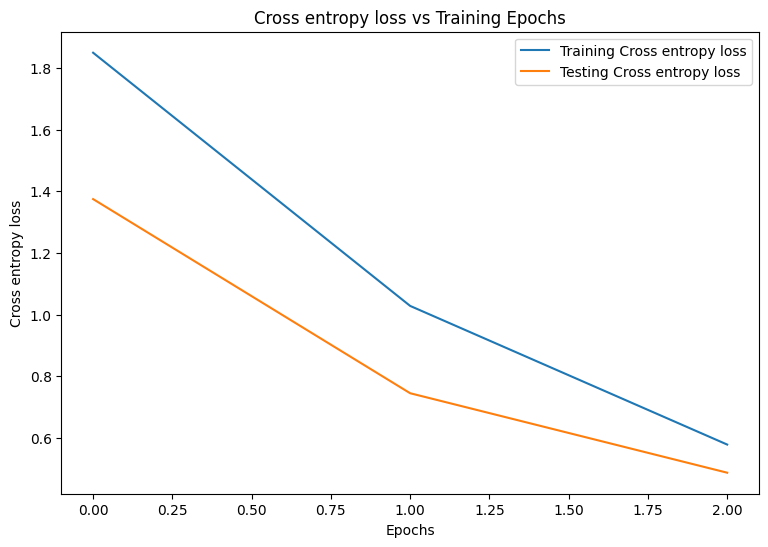

In [17]:
plot_metrics(train_losses, test_losses, "Cross entropy loss")

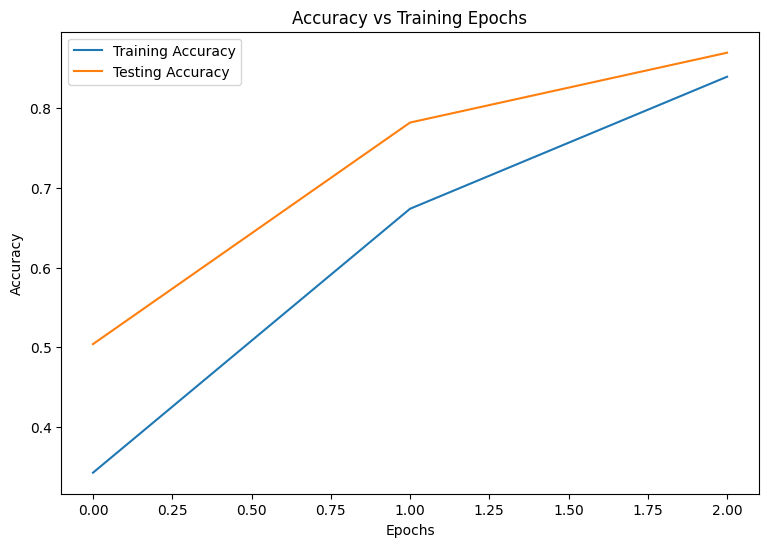

In [18]:
plot_metrics(train_accs, test_accs, "Accuracy")

## モデルの保存

`tf.saved_model` と DTensor の統合はまだ開発中です。TensorFlow 2.9.0 の時点で、tf.saved_model は完全に複製された変数を持つ DTensor モデルのみを受け入れます。回避策として、チェックポイントをリロードすることで、DTensor モデルを完全に複製されたモデルに変換できます。ただし、モデルを保存すると、すべての DTensor アノテーションが失われ、保存されたシグネチャは通常の Tensor でのみ使用できます。統合されたら、このチュートリアルのデモは更新されます。


## 結論

このノートブックでは、DTensor と TensorFlow Core API を使用した分散トレーニングの概要を説明しました。以下に役立つヒントをいくつか紹介します。

- [TensorFlow Core API](https://www.tensorflow.org/guide/core) を使用すると、分散型トレーニングをサポートする高度に構成可能な機械学習ワークフローを構築できます。
- [DTensor の概念](https://www.tensorflow.org/guide/dtensor_overview)ガイドと [DTensor を使用した分散型トレーニング](https://www.tensorflow.org/tutorials/distribute/dtensor_ml_tutorial) チュートリアルには、DTensor とその統合に関する最新情報が含まれています。

TensorFlow Core API のその他の使用例については、[チュートリアル](https://www.tensorflow.org/guide/core)を参照してください。データの読み込みと準備についてさらに学習するには、[画像データの読み込み](https://www.tensorflow.org/tutorials/load_data/csv)または <a>CSV データの読み込み</a>に関するチュートリアルを参照してください。